In [1]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
from collections import Counter
from sklearn.utils import shuffle
import albumentations as A
from sklearn.svm import SVC
from random import random
from pathlib import Path
from tqdm import tqdm
import numpy as np
import math
import cv2
import os

In [2]:
#declare variables and create augmented directories
dataset_path = "../dataset"
n_augmented_class=500
image_size = (224, 224)
classes = ["glass", "paper", "cardboard", "plastic", "metal", "trash"]
unknown_class = "unknown"
n_augmented_unknown=n_augmented_class+50 # n_augmented_class + n for test
#delete existing augmented files
dataset_path = Path(dataset_path)  # make sure it's a Path object

for cls in classes:
    aug_dir = dataset_path  / cls/ "augmented"

    # Create folder if not exists
    aug_dir.mkdir(parents=True, exist_ok=True)

    # Delete all existing files inside
    for file in aug_dir.iterdir():
        if file.is_file():
            file.unlink()

In [3]:
all_files = []
all_labels = []

for idx, cls in enumerate(classes):
    class_folder = os.path.join(dataset_path, cls)
    if not os.path.isdir(class_folder):
        print(f"Warning: Folder not found: {class_folder}")
        continue

    for f in os.listdir(class_folder):
        if not (f.endswith(".jpg") or f.endswith(".png")):
            continue
        file_path = os.path.join(class_folder, f)

        img = cv2.imread(file_path)
        if img is None:
            print(f"Warning: Cannot open image {file_path}, skipping.")
            continue
        all_files.append(file_path)
        all_labels.append(idx)

train_files, test_files, train_labels, test_labels = train_test_split(
    all_files, all_labels, test_size=0.25, shuffle=True, stratify=all_labels,random_state=42
)

In [4]:
# Define augmentation pipeline for training data without unknown class
transform = A.Compose([
  A.SomeOf([
        A.HorizontalFlip(p=0.5,random_state=42),
        A.Rotate(limit=45, p=0.5,random_state=42),
        A.VerticalFlip(p=0.5,random_state=42),
        A.ShiftScaleRotate(
            shift_limit=0.0,      
            scale_limit=0.2,
            rotate_limit=0,
            border_mode=0,
            p=0.5,random_state=42
        ),
        A.RandomCrop(width=128, height=128, p=0.5,random_state=42),
    ], n=3),
    A.OneOf([
        A.RandomBrightnessContrast(
            brightness_limit=0.2,
            contrast_limit=0.2,
            p=1.0,random_state=42
        ),
        A.HueSaturationValue(
            hue_shift_limit=10,
            sat_shift_limit=15,
            val_shift_limit=10,
            p=1.0,random_state=42
        ),
    ], p=0.7),

    # ----- Noise & Blur -----
    A.OneOf([
           A.GaussNoise(var_limit=(10, 50), p=1.0,random_state=42),
    A.GaussianBlur(blur_limit=3, p=1.0,random_state=42)
    ], p=0.3),
])


C:\Users\ts\AppData\Local\Temp\ipykernel_15140\3346715144.py:4: UserWarning: Argument(s) 'random_state' are not valid for transform BasicTransform
  A.HorizontalFlip(p=0.5,random_state=42),
C:\Users\ts\AppData\Local\Temp\ipykernel_15140\3346715144.py:5: UserWarning: Argument(s) 'random_state' are not valid for transform Rotate
  A.Rotate(limit=45, p=0.5,random_state=42),
C:\Users\ts\AppData\Local\Temp\ipykernel_15140\3346715144.py:6: UserWarning: Argument(s) 'random_state' are not valid for transform BasicTransform
  A.VerticalFlip(p=0.5,random_state=42),
d:\installation\python\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\ts\AppData\Local\Temp\ipykernel_15140\3346715144.py:7: UserWarning: Argument(s) 'random_state' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(
C:\Users\ts\AppData\Local\Temp\ipykerne

In [5]:
# Function to perform data augmentation
def data_autgmentation(img_path, output_folder, aug_times=5):
    img_name = os.path.basename(img_path)
    img = cv2.imread(img_path)
    if img is None:
        print(f"ERROR: Cannot load image {img_path}. Skipping.")
        return
    for i in range(aug_times):
        augmented = transform(image=img)
        aug_img = augmented["image"]
        aug_img_name = f"{os.path.splitext(img_name)[0]}_aug_{i+1}.jpg"
        aug_img_path = os.path.join(output_folder, aug_img_name)
        cv2.imwrite(aug_img_path, aug_img)
    print(f"Augmented {aug_times} images for {img_name}")

In [6]:
# Perform augmentation to balance classes 
class_counts = Counter(train_labels)

for cls_idx, cls_name in enumerate(classes):
    
    cls_images = [img for i, img in enumerate(train_files) if train_labels[i] == cls_idx]
    current_count = class_counts[cls_idx]
    aug_needed = max(0, n_augmented_class - current_count)
    
    if aug_needed == 0:
        continue
    
    output_folder = os.path.join(dataset_path, cls_name, "augmented")
    
    times_per_image = math.ceil(aug_needed / len(cls_images))
    count=0
    for img_path in tqdm(cls_images, desc=f"Augmenting {cls_name}"):
        if count>= aug_needed:
            break
        data_autgmentation(img_path, output_folder, times_per_image)
        count=count+times_per_image

Augmenting glass:   5%|▍         | 14/289 [00:00<00:04, 67.21it/s]

Augmented 1 images for 41f2968d-9fb6-4f44-a21a-770bcdf43a1c.jpg
Augmented 1 images for 153b425a-92d4-490d-847d-e951a41c3e61.jpg
Augmented 1 images for 800b54d9-14a7-41f3-bfd4-24987d327833.jpg
Augmented 1 images for dd05ff8d-ad7c-4ec5-94af-db663dd77d3c.jpg
Augmented 1 images for 0badb460-d33c-4a67-8fc7-3a62de33d30b.jpg
Augmented 1 images for eb8d5eee-bb10-4af2-94dd-7a730875ccca.jpg
Augmented 1 images for 103c828b-b8f5-4889-8507-bc0361bd5f2e.jpg
Augmented 1 images for 259cc3b2-e2e6-4a9b-bb27-9627fca2b124.jpg
Augmented 1 images for ef5bfc3a-cf26-47b1-b77e-3f259c72707c.jpg
Augmented 1 images for fd99a204-20a6-4290-9850-d9af48ef1562.jpg
Augmented 1 images for 569336ae-e887-49d2-a749-c52392948e3c.jpg
Augmented 1 images for f9e6e7cc-a81e-4259-a184-2b61622a5644.jpg
Augmented 1 images for 17d73815-7735-41c0-a9eb-363b24d72b2e.jpg
Augmented 1 images for 2a26b7a0-c149-410c-b793-508dfab97e94.jpg
Augmented 1 images for d51f4539-7e10-4c40-933b-35d9adaa5bd7.jpg
Augmented 1 images for f23fb4d7-dd84-49d

Augmenting glass:  19%|█▉        | 55/289 [00:00<00:01, 159.49it/s]

Augmented 1 images for d1b449fd-bcb6-4053-abad-aa985e692540.jpg
Augmented 1 images for 6763da26-9208-4935-b33b-7ad0ba56a406.jpg
Augmented 1 images for 6e41c644-269e-4bb3-926d-4637a72f9906.jpg
Augmented 1 images for 69b725d7-dd12-4b20-850a-29a35e29a041.jpg
Augmented 1 images for 3ce8f116-fe6c-46e3-9af8-a7248a06febd.jpg
Augmented 1 images for 54a3564c-456a-4611-9ac9-fe8e9a990e7b.jpg
Augmented 1 images for 4bb65281-7604-4a9b-b689-35b7572b0a8f.jpg
Augmented 1 images for fa8c3815-62f6-4453-95bf-808515f946bc.jpg
Augmented 1 images for 46e0469a-c98c-4e87-9a53-5fe50eca7611.jpg
Augmented 1 images for 6cc42a3b-901a-4780-8e33-542e914cf140.jpg
Augmented 1 images for adeaef42-c1fd-4f4b-8271-4dc7633b52a8.jpg
Augmented 1 images for 1f0cb428-fb88-4769-9d6a-d54cb1cf6a94.jpg
Augmented 1 images for 2d19e691-2779-4d5b-b969-b6cb6c62c6a7.jpg
Augmented 1 images for df899682-6d94-43e0-aaba-9392d3c3c79d.jpg
Augmented 1 images for 42e83751-4a5a-4da0-9038-3957b48816da.jpg
Augmented 1 images for 50e5bbbf-b492-425

Augmenting glass:  33%|███▎      | 94/289 [00:00<00:01, 164.73it/s]

Augmented 1 images for 0ee7f289-a78e-4448-b182-bf5bdc4b9298.jpg
Augmented 1 images for dabd3cbb-8c05-400b-bd81-6789ae43c142.jpg
Augmented 1 images for a60db94d-4154-4937-bbab-9f37353fc694.jpg
Augmented 1 images for a4e6c3d5-eb9d-4ba6-8537-bff9e2821d2b.jpg
Augmented 1 images for 66e2d683-8450-413a-b68d-088e9e0711c7.jpg
Augmented 1 images for 3f000fd6-0da9-40e7-bcfd-a69d1f93af98.jpg
Augmented 1 images for 5956d97a-44ef-4a95-9cd1-18eb62b23ea1.jpg
Augmented 1 images for f5caf374-9bb9-4539-80e6-c92ad594551d.jpg
Augmented 1 images for a971c2e5-a970-4af2-957b-63f6f96df0b7.jpg
Augmented 1 images for 6cf50200-2c63-471a-81b9-03778553ee60.jpg
Augmented 1 images for 3675b7d4-cf82-4233-a513-0c26479abdf7.jpg
Augmented 1 images for 338cf08c-86a2-444a-abb1-0599022f1870.jpg
Augmented 1 images for bd252172-a40d-46b4-9517-bc8441cfcc90.jpg
Augmented 1 images for 6895edff-558e-43e1-be00-2c6520d6a862.jpg
Augmented 1 images for 5a5f25f6-b1f1-4b2d-a05d-461c854c2ac0.jpg
Augmented 1 images for 021f2594-7af3-45e

Augmenting glass:  46%|████▌     | 133/289 [00:00<00:00, 174.98it/s]

Augmented 1 images for 85ce3417-cb3c-473d-b9b8-75572ff08530.jpg
Augmented 1 images for f3963a29-af56-415e-a58a-f19d43603bb6.jpg
Augmented 1 images for 185aa5a3-14ef-4cdb-82aa-939901f6809c.jpg
Augmented 1 images for 237f4019-28df-4612-97f5-6899a14aded4.jpg
Augmented 1 images for e2589c16-148e-4dfd-8a34-8f8e59c6a066.jpg
Augmented 1 images for c240cd3f-576b-4253-bf5e-74178937e3b0.jpg
Augmented 1 images for 1c673af2-01a2-4128-a565-3d372ab6fe10.jpg
Augmented 1 images for 3ce5ef4b-e7a6-42c8-b765-3c213079e01b.jpg
Augmented 1 images for fd6cae6e-4fb4-4eb5-81e6-f327f8a11c80.jpg
Augmented 1 images for 4681f631-5d07-4e20-a590-7a716f25e79f.jpg
Augmented 1 images for 6ca97f5c-708f-48da-aa04-d69ebe175d50.jpg
Augmented 1 images for fda0c6db-f46e-404b-835c-79436b10e202.jpg
Augmented 1 images for 89b7d25e-91b0-4f5b-a390-704bb024a37f.jpg
Augmented 1 images for 595d50bf-97bd-4184-b660-08c921f07de4.jpg
Augmented 1 images for 75d4ba82-ede8-4e69-aa19-b4b5592e9f5e.jpg
Augmented 1 images for 0f5c9c27-9cad-49e

Augmenting glass:  60%|█████▉    | 172/289 [00:01<00:00, 178.88it/s]

Augmented 1 images for 5c624c63-cd70-4636-8dc0-b27584ade9cd.jpg
Augmented 1 images for 8b91aa0e-7238-4ad7-924c-20448018b022.jpg
Augmented 1 images for 0b574a63-63f5-4bba-a748-04422c3b8885.jpg
Augmented 1 images for 9a4e7bc9-cde3-4848-b699-6053c50e30fa.jpg
Augmented 1 images for b31f6b58-7109-4156-8631-6827fc2824d0.jpg
Augmented 1 images for f88c741b-6e7d-4d94-8922-c07270c77139.jpg
Augmented 1 images for 428edd38-9270-4c9f-8da8-226be6ec1308.jpg
Augmented 1 images for cfc1966b-3118-4ceb-bc00-86024eb01ecd.jpg
Augmented 1 images for 125d8ecb-a621-4349-9123-a61a99db77a9.jpg
Augmented 1 images for 64b66c3c-c28b-4fd1-9d81-aea887861d5d.jpg
Augmented 1 images for becf8ed9-64c4-4501-8b84-ac1083923f5f.jpg
Augmented 1 images for 05e8891d-f88a-4892-8f7d-133da571a264.jpg
Augmented 1 images for 7b75102b-32ef-423b-bd0f-c5b67c7ee4fc.jpg
Augmented 1 images for 5a126edf-8845-4322-96ad-a4cce0611b1b.jpg
Augmented 1 images for 81b62af4-64e7-4f9a-8c82-e3e6ad268acb.jpg
Augmented 1 images for 701b57e2-b6fa-46b

Augmenting glass:  73%|███████▎  | 211/289 [00:01<00:00, 166.41it/s]


Augmented 1 images for 001d641f-13b4-46d5-b4ed-7d3d11ff34f8.jpg
Augmented 1 images for 59281bd8-f594-4f95-9518-9641bcdca673.jpg
Augmented 1 images for 58bcdd67-b3f7-4fbf-938c-47918d9504ca.jpg
Augmented 1 images for c3705138-298a-4de3-8ee8-f1825372cd70.jpg
Augmented 1 images for 26215ecd-f3d6-4b07-be2b-73fc19cc6965.jpg
Augmented 1 images for 4ab7f8da-a96d-40da-ac24-7a7ae718079f.jpg
Augmented 1 images for 6ed22952-382b-4b22-b75d-70634622d8a6.jpg
Augmented 1 images for 6d297a08-5b3e-4f61-b567-835cb5d21a9c.jpg
Augmented 1 images for 89686a39-e2c7-4007-b069-21439aea9d0d.jpg
Augmented 1 images for 2dd74afc-6d33-4db3-b741-fdf031e6a516.jpg
Augmented 1 images for d199b6ad-79dd-405e-8b0e-f61b24b1b0b6.jpg
Augmented 1 images for be7dab12-60a0-4f85-b4aa-2b8062724b7d.jpg
Augmented 1 images for 30d9a04e-1648-4eb8-bc96-ca0d33e59657.jpg
Augmented 1 images for 751b62a1-22a3-4513-91cd-61c2e42b9852.jpg
Augmented 1 images for 0ec28c79-21d2-4169-9a73-8cd3bce41632.jpg
Augmented 1 images for 8f539575-f2c7-458

Augmenting paper:   0%|          | 0/337 [00:00<?, ?it/s]

Augmented 1 images for 87dc0b15-5e5d-4e47-9c5f-c9c48733724b.jpg
Augmented 1 images for aa238cd4-1eb4-455d-9c1c-7ed2c34828ed.jpg
Augmented 1 images for 8f3ee08d-4a61-44b5-a83a-488795c18d55.jpg
Augmented 1 images for 7004fe13-3ea6-4eb3-adc5-3f3643b9f5ba.jpg
Augmented 1 images for 8843694a-0e83-4335-97ad-85d686fecf55.jpg
Augmented 1 images for d3468a2d-bbb1-4c09-86c0-2de4e7bbd325.jpg
Augmented 1 images for 18537087-0584-4ec8-b820-9217362dc62d.jpg
Augmented 1 images for 640b38de-4f45-4780-b12a-ea96c5081014.jpg
Augmented 1 images for baf7aed0-f161-44af-9131-ea63074c427a.jpg
Augmented 1 images for 0ee05340-b68a-44e5-be5e-146595abca5f.jpg
Augmented 1 images for 666a0951-16d1-489c-a1a2-59010cbcc1e3.jpg
Augmented 1 images for da395a83-cbf7-4c6f-a459-af74b73e51ee.jpg
Augmented 1 images for e1989807-0b1b-4117-9009-f9db8bc73c6c.jpg
Augmented 1 images for b5072f90-1f56-46b2-b111-b09931e92494.jpg
Augmented 1 images for ef3dd789-47ab-4214-b481-b66a42f9a01c.jpg
Augmented 1 images for 305d0664-afd6-4b5

Augmenting paper:  11%|█         | 37/337 [00:00<00:01, 183.98it/s]

Augmented 1 images for 3b7b997f-0e03-464a-b248-b7139569ae76.jpg
Augmented 1 images for f8e507fa-3a8d-4313-8d39-c00f8222b80b.jpg
Augmented 1 images for 22faaa68-81a9-43d1-8cb0-54959fd58ff7.jpg
Augmented 1 images for 6f799950-21a1-4c7b-8155-0f5bb6ba99ee.jpg
Augmented 1 images for 4385995c-c863-4c9f-add5-2014f811812f.jpg
Augmented 1 images for c99dddb9-22aa-4157-adcd-4286e7f99ae3.jpg
Augmented 1 images for 1333e4f2-47a9-4cb2-b51c-b526c149263d.jpg
Augmented 1 images for 81cc087c-df9d-43d7-905f-cc35dc51c88a.jpg
Augmented 1 images for 51087671-4fc6-4d7d-a3d2-be35d2cc3db1.jpg
Augmented 1 images for 7354c56e-c477-4098-b898-f103ee1f2254.jpg
Augmented 1 images for 7c0fe3d6-07f0-4243-96ea-119423c0c987.jpg
Augmented 1 images for 3806bb4b-9e9c-4a23-a99a-cd5c1f5b07a7.jpg
Augmented 1 images for b6fce795-e695-4761-ab5b-796057642f5d.jpg
Augmented 1 images for 7b01c997-3282-4a70-aa50-7872a452b50b.jpg
Augmented 1 images for c02c4abd-6e11-4c90-a428-6395aad138ec.jpg
Augmented 1 images for 3114a21c-7106-4ad

Augmenting paper:  17%|█▋        | 58/337 [00:00<00:01, 181.43it/s]

Augmented 1 images for 1a296560-8141-4516-bbd7-3f8a8b3e0897.jpg
Augmented 1 images for a718997d-1d54-4a45-a9c1-363da3192049.jpg
Augmented 1 images for 2bb49a42-c6e4-4cb1-a8d2-a89aba58414e.jpg
Augmented 1 images for 6b5e8d37-86de-4b0a-8292-12d0cdea2f9a.jpg
Augmented 1 images for 6f036979-393e-47c1-99f3-3a1900fe62ff.jpg
Augmented 1 images for 68e0ad99-208e-4a16-ad4f-421b9351ec75.jpg
Augmented 1 images for ccf799cb-abf0-447d-8578-b1b90fabc456.jpg
Augmented 1 images for a6d588cd-b07c-4a01-9ec5-848b06353b8b.jpg
Augmented 1 images for 4cbe8c71-a641-4da5-a6ec-8329c1b29f21.jpg
Augmented 1 images for 82af8dd4-e3b6-49ab-af38-52bff882c16d.jpg
Augmented 1 images for 637d19bc-169e-42a3-82e8-896f5ffb3d5f.jpg
Augmented 1 images for fce78d4a-0a0e-4dd8-8ab2-606c05df53c3.jpg
Augmented 1 images for ca7ce372-53be-4957-b9c0-29544b52e076.jpg
Augmented 1 images for c16ff768-c65e-46e7-8102-da1de35fd33f.jpg
Augmented 1 images for d0cf0325-c99a-4211-a6cf-4519431b1768.jpg
Augmented 1 images for 0c568586-028a-480

Augmenting paper:  25%|██▌       | 85/337 [00:00<00:01, 202.00it/s]

Augmented 1 images for a70b4b23-9c4c-4fb0-84b5-80ef1cf96a60.jpg
Augmented 1 images for 0ba865ef-01dd-44c3-ad0b-d20e0b38e2f9.jpg
Augmented 1 images for 2e85a535-70d5-48f5-8e9c-fdd1a99158e3.jpg
Augmented 1 images for b5ad6f0b-9c5d-403b-a780-91fb853b5dbf.jpg
Augmented 1 images for e1775093-982d-4151-8fce-7be4eef61c53.jpg
Augmented 1 images for cf3f1afc-e166-4b93-8e1c-498be298408b.jpg
Augmented 1 images for 7f4c05b4-c039-492e-aa72-60bd4f499a88.jpg
Augmented 1 images for 0f7b2976-4e02-4217-8c89-725cd91b28cf.jpg
Augmented 1 images for 92ef2109-c3b0-4352-820b-61c121577fbe.jpg
Augmented 1 images for dfa2812f-2815-48ee-b568-4ef2f992a382.jpg
Augmented 1 images for f92974f7-fdc3-4abd-aade-42d20bc43376.jpg
Augmented 1 images for a588caea-69d6-4c04-9c3d-02cf8b569f56.jpg
Augmented 1 images for 619dc4d3-d833-41a7-93c6-e6ee8b96303e.jpg


Augmenting paper:  31%|███▏      | 106/337 [00:00<00:01, 167.90it/s]

Augmented 1 images for 8d015851-d523-4907-9ed0-3991e8ff3b1d.jpg
Augmented 1 images for fc5aa9d5-4f71-49df-9fae-2742f9fc028d.jpg
Augmented 1 images for 88753f7f-f33b-4bfc-9ec2-e2d1b8aec40e.jpg
Augmented 1 images for 6d99e528-8b1a-46a6-b545-3986c1e86c14.jpg
Augmented 1 images for 8f316c3b-e1aa-4827-be57-1e6440978638.jpg
Augmented 1 images for 2f524c45-d60e-4e2e-9c22-a13ac9720e40.jpg
Augmented 1 images for a1d4231c-9851-4645-9c19-797e8f7bb0f9.jpg
Augmented 1 images for a04e2057-f868-4168-9ea0-735706860e22.jpg
Augmented 1 images for e16103eb-0a6e-4b18-8f54-36bc199c4069.jpg
Augmented 1 images for 28013d05-ce9f-46f7-9b11-9468f9d923d3.jpg
Augmented 1 images for a9f19cb3-4a22-4bc1-b941-5b6e24f53218.jpg
Augmented 1 images for a21c987b-2b68-4acd-9aa7-47b820289851.jpg
Augmented 1 images for d011a272-d562-494a-991e-9a1a4a3e9c3d.jpg
Augmented 1 images for 5dd92ee4-11fd-4e9a-974b-42093b9479f6.jpg
Augmented 1 images for 4f244c30-15f0-49e4-a458-55dd24769945.jpg
Augmented 1 images for 6c496eb6-534a-447

Augmenting paper:  37%|███▋      | 125/337 [00:00<00:01, 165.28it/s]

Augmented 1 images for 6b8972ea-cf3a-4653-b481-a534e98f750d.jpg
Augmented 1 images for 9ced7685-0f03-4512-8011-48a57f439830.jpg
Augmented 1 images for fdd00b90-1977-4e14-9c83-ef1a280e68c9.jpg
Augmented 1 images for 017321ed-46b0-4dca-bced-8c44a61c025a.jpg
Augmented 1 images for 643c1fb6-8c5e-4522-abcc-8a73ca03c8cb.jpg
Augmented 1 images for fe5e637a-51ee-4994-b170-0ba5eae825d4.jpg
Augmented 1 images for 387d1f4c-b11e-49cc-b060-0c21924d66a4.jpg
Augmented 1 images for 627edd3b-9692-41e4-add2-14a90003bf9c.jpg
Augmented 1 images for d541ee61-9ea9-4c30-84b3-13c2d325210b.jpg
Augmented 1 images for 83337c7d-a5dd-4c4d-be81-77df2aa0fd6b.jpg
Augmented 1 images for d1658904-b32e-4632-bd09-68ec76c670ab.jpg
Augmented 1 images for f7adb18a-f47f-492b-bdca-e73f82ddacc7.jpg
Augmented 1 images for 53bb8bc8-42cd-4981-84dd-d42ae7bc8348.jpg
Augmented 1 images for 8f77a32c-7b80-4a3a-b846-aec0a0acd001.jpg
Augmented 1 images for 667af464-ba4e-4901-a060-c146f1964955.jpg


Augmenting paper:  42%|████▏     | 142/337 [00:00<00:01, 152.82it/s]

Augmented 1 images for bef4efa1-3690-4a7a-814d-ae83ad14ae56.jpg
Augmented 1 images for f714a365-3606-46f2-b223-0a57998762be.jpg
Augmented 1 images for c1c95a3b-f15b-40c0-a8eb-9e7f38533a82.jpg
Augmented 1 images for 8428b9c2-9bc8-40aa-b8df-381e326ea7be.jpg
Augmented 1 images for 5a662bba-29a8-4b91-9f2b-35748f036a46.jpg
Augmented 1 images for 92db16c7-5323-4cbe-99bc-bee675f65ab6.jpg
Augmented 1 images for e1dc5706-c8a1-4015-95d9-d5f68601bcb3.jpg
Augmented 1 images for a2708075-4699-4478-a601-fa26dea07826.jpg
Augmented 1 images for 78bee59f-0ef7-4ee8-aa12-92b00d3fee37.jpg
Augmented 1 images for 7d6d16ee-a613-4885-93df-6598777e57fc.jpg
Augmented 1 images for 3d571b65-7297-4aaa-b195-e09356d70bc2.jpg
Augmented 1 images for 777f9395-e0ae-46e7-bd02-111244d028b8.jpg


Augmenting paper:  48%|████▊     | 163/337 [00:00<00:01, 163.96it/s]


Augmented 1 images for 4d5385d8-30f4-426e-a89e-e18d72ef183d.jpg
Augmented 1 images for 1f3b2079-2226-454c-8557-1419da6b9d83.jpg
Augmented 1 images for 7adefd78-ad80-4c9c-a09b-9f92aa723a67.jpg
Augmented 1 images for 87fdbec0-4f84-4355-af49-9b1d243c0bed.jpg
Augmented 1 images for 83c2fec9-4a2b-4f3e-8f8e-88f49b87e7f6.jpg
Augmented 1 images for d6bf9da3-5245-4e32-b3e1-5b5641b29f2e.jpg
Augmented 1 images for 3514d59d-ca36-43d4-acc6-977f4a3f1669.jpg
Augmented 1 images for f062538e-11e2-44a4-bb8b-3b748289bc00.jpg
Augmented 1 images for e0be76ec-f4de-403c-a6f7-892bc77da73e.jpg
Augmented 1 images for 82647fac-0f12-41fc-acfd-583ec9fa3a92.jpg
Augmented 1 images for 83f6e9c0-227b-4027-b492-3d596f8ea6fc.jpg


Augmenting cardboard:   0%|          | 0/185 [00:00<?, ?it/s]

Augmented 2 images for 22eac89d-12bb-48f1-a3db-41897bda0d0c.jpg

Augmenting cardboard:   4%|▍         | 8/185 [00:00<00:02, 75.48it/s]


Augmented 2 images for a028b27d-36c6-4f3e-ad02-84794cae297a.jpg
Augmented 2 images for 8f704f76-2a72-4665-af91-023a06f8009b.jpg
Augmented 2 images for a695a288-1304-4aa4-b26f-6c38a9faf768.jpg
Augmented 2 images for 97e64de1-a5f8-4f90-bf61-d59e6594985e.jpg
Augmented 2 images for dac067ae-1072-4a03-bfc1-6c0e50f80e04.jpg
Augmented 2 images for 4e01b0cc-db7c-416a-94e7-1f1da0783f9b.jpg
Augmented 2 images for eea8a36c-0468-40b6-a3f4-30bdecacf009.jpg
Augmented 2 images for 1252308f-0805-4cdc-92ec-c0fe5915c24f.jpg
Augmented 2 images for cc46fd45-5138-4aa8-a39a-ddc144d7b079.jpg
Augmented 2 images for 6a9710cb-ceb5-4f76-afdf-78f60d36a321.jpg
Augmented 2 images for 4e11ed97-f166-459a-ad6d-75a6e0c66870.jpg


Augmenting cardboard:   9%|▉         | 17/185 [00:00<00:02, 83.67it/s]

Augmented 2 images for 0149d275-f23d-477c-a5be-4b10f13d1fad.jpg
Augmented 2 images for 734e5365-20cd-4e64-87ff-86008db53675.jpg
Augmented 2 images for b630964c-a819-4770-95e4-2a0982197091.jpg
Augmented 2 images for 676e0cd2-cee3-4f47-bf2d-8ddc9a722c23.jpg
Augmented 2 images for 6c1d24ea-af2c-44a5-a941-4a414a0a6583.jpg


Augmenting cardboard:  14%|█▍        | 26/185 [00:00<00:02, 75.44it/s]

Augmented 2 images for d2498953-8164-47e9-9f3e-58c245c51688.jpg
Augmented 2 images for b5635d87-90c4-452a-b777-0e97562850fb.jpg
Augmented 2 images for b559ffdd-8713-4324-8b30-5c3f757a5750.jpg
Augmented 2 images for a7d9c64f-3632-422a-9dc5-02f54644b47b.jpg
Augmented 2 images for 89f47eba-f3ea-425c-a0c5-231536d770d6.jpg
Augmented 2 images for 81f25e4f-f92f-44be-8545-9e5a5b9f91ed.jpg
Augmented 2 images for 0a852349-3675-4471-9f16-bed7d5f7ec76.jpg
Augmented 2 images for 69486b33-0211-42ce-8c26-79add418696b.jpg
Augmented 2 images for 087cd7d6-6b80-4a68-b9d5-5a40a70ebe04.jpg
Augmented 2 images for 89535da2-fbfe-45a2-985f-728a1343c7e5.jpg
Augmented 2 images for 4b54af80-1a75-473f-9bad-62e9053b2f05.jpg
Augmented 2 images for 42057cdf-66bd-4836-856c-c32287d150c9.jpg
Augmented 2 images for 3a59c0af-78c8-47ed-bd92-78c9de172c78.jpg
Augmented 2 images for 3e8de665-6428-456f-bcdb-1cab40b8b285.jpg
Augmented 2 images for 7f77ab25-99fc-4597-8e57-57c55cc00007.jpg
Augmented 2 images for 5381847f-99b0-435

Augmenting cardboard:  24%|██▍       | 45/185 [00:00<00:01, 77.28it/s]

Augmented 2 images for 12e978b5-420e-49e1-8658-17ed8f49ec2a.jpg
Augmented 2 images for 9546dddb-61ad-4591-a355-b94fa435384a.jpg
Augmented 2 images for 3896e55a-e949-427f-b02c-1132874a2b76.jpg
Augmented 2 images for 98c47208-30a9-4fc4-9941-6833502eb437.jpg
Augmented 2 images for 3b60ce96-4472-4918-afbc-ae5298852948.jpg
Augmented 2 images for 9f5b90b7-f297-40d5-b1aa-0e97f9011b8b.jpg
Augmented 2 images for 5eb440f9-d6d8-40df-9c62-2edff0746d4a.jpg
Augmented 2 images for f47792d8-9c58-4c49-9541-bb3bf542a575.jpg
Augmented 2 images for 9fd8e199-559e-43e4-ba71-5ad6a536e65b.jpg
Augmented 2 images for 7ccd2e20-9efb-4e64-bd79-57de911b0ab3.jpg
Augmented 2 images for 7dd7139b-a652-45ab-80ba-41e17e0363de.jpg
Augmented 2 images for 766dde7b-437f-4fb1-ba41-e2eba273ec78.jpg
Augmented 2 images for e5eb43e6-b502-469a-b23e-930d46c51c5e.jpg
Augmented 2 images for 1723a978-0bf4-4f15-947d-245b7f26a4ee.jpg
Augmented 2 images for 6e780861-ee4e-43d2-85ff-ec0d60676898.jpg
Augmented 2 images for e0715536-1d12-417

Augmenting cardboard:  31%|███▏      | 58/185 [00:00<00:01, 88.84it/s]

Augmented 2 images for a11e1693-57cb-4c9e-a1c2-320134048837.jpg
Augmented 2 images for 059dcd74-da75-4c2c-93e9-78b60c1333c6.jpg
Augmented 2 images for 412dc59f-bf0c-4988-8d0e-7e3565e67eba.jpg
Augmented 2 images for affbe93b-e51c-4933-8e37-46cac0f696ad.jpg
Augmented 2 images for 2346380e-5f46-4603-8966-1e713c41d993.jpg
Augmented 2 images for 89f15ea8-ab5c-47c9-b7e3-aa1c8c2646c4.jpg
Augmented 2 images for 4ff1f313-3083-4261-aab5-78e313673c09.jpg
Augmented 2 images for c8040630-1679-42ed-a483-d2b780ba6e37.jpg
Augmented 2 images for c9c33ea0-18a1-4ce0-9f89-05fb72b7eb86.jpg
Augmented 2 images for 2fbdea77-1129-4be4-8014-8667aa793080.jpg
Augmented 2 images for 608b7b7d-a4b1-457c-86dc-633ec96f2eb4.jpg
Augmented 2 images for a4b199b6-13b8-4965-a28e-3219fadd1cd7.jpg
Augmented 2 images for 6c90a0ff-1a56-4d44-8b68-033b267b7bc8.jpg
Augmented 2 images for f6e475a4-5e95-424d-ba42-73d986f16509.jpg
Augmented 2 images for f9b66097-b9af-47a0-80ef-9f1f729c970c.jpg
Augmented 2 images for 34538efa-7116-440

Augmenting cardboard:  42%|████▏     | 78/185 [00:00<00:01, 83.78it/s]

Augmented 2 images for 8fb95bb3-12b8-4c90-88f0-4270de2c42bd.jpg
Augmented 2 images for d83ab622-8ad3-4add-8c75-c88427740fb5.jpg
Augmented 2 images for e609456e-4176-4518-999b-8e83e1050cbd.jpg
Augmented 2 images for aeeef2b3-380f-4fc7-9f07-15029a24e02b.jpg
Augmented 2 images for 9290ef92-1f28-4ad4-abce-7c3233ac091c.jpg
Augmented 2 images for 8c383ad8-619a-4794-b30f-fd6b3b5d7fda.jpg
Augmented 2 images for a5b01d69-c114-43f2-a042-9bf22433501c.jpg
Augmented 2 images for 9ffcaf5e-4e1f-4bdf-b4ae-09adb75f9d32.jpg
Augmented 2 images for 1123d19a-9409-4671-b507-a3dd35062a74.jpg
Augmented 2 images for e5b9c81b-707f-44a0-ba1b-dbfbde5fc266.jpg
Augmented 2 images for 91eb8388-efbc-437a-a0f1-089c3a5a7572.jpg
Augmented 2 images for bf2d84a9-0bd2-458f-bc09-c4f3497cd927.jpg
Augmented 2 images for aa2bfd22-f31a-4707-ba6a-eda8cb3edb5c.jpg
Augmented 2 images for e9d32c5a-e3c9-4794-b13f-d13265167410.jpg
Augmented 2 images for 83200b0d-9dcc-416b-a891-3ec6beaef1f9.jpg
Augmented 2 images for 57cd9e12-c83a-49f

Augmenting cardboard:  52%|█████▏    | 97/185 [00:01<00:01, 80.25it/s]

Augmented 2 images for 31824a1e-17b3-4f83-89b4-0f5c2994b44a.jpg
Augmented 2 images for 1669e85b-df4e-43b1-87f9-25dc7826a933.jpg
Augmented 2 images for b8ad844e-b68c-4ceb-a4ab-8511d758e0c4.jpg
Augmented 2 images for b195a07b-965c-4775-a902-c9e41d2ceafb.jpg
Augmented 2 images for 6ea71282-473c-4bd4-995e-520d20b43ea2.jpg
Augmented 2 images for d4fff235-8a36-4a58-9784-8b0ab260479c.jpg
Augmented 2 images for 8889b2d4-0175-454a-9da5-e736c812111c.jpg
Augmented 2 images for dd31f982-e34b-42b6-987d-0704a5b5f2c2.jpg
Augmented 2 images for 19a5d52e-8c64-4e6c-810e-252651ed9b0d.jpg
Augmented 2 images for b77e06da-b89a-454f-ab72-8cdee8d20f41.jpg
Augmented 2 images for b2e57dea-4189-40b1-bf3b-4b4aedf31ac3.jpg
Augmented 2 images for c8af5d8a-88ef-452b-b859-a144513d4c86.jpg
Augmented 2 images for a20e79c2-f19c-4692-aba4-b7a90b69fe01.jpg
Augmented 2 images for 3769828d-6e2d-4712-ba33-061e6c943a49.jpg
Augmented 2 images for c3864510-3ef3-4a15-92fd-1efbbbebc94e.jpg
Augmented 2 images for 2c13c3aa-cd86-421

Augmenting cardboard:  59%|█████▉    | 110/185 [00:01<00:00, 92.69it/s]

Augmented 2 images for 95fb5ccf-c21c-4d75-b508-d44cd4f83f13.jpg
Augmented 2 images for eeaf0c89-a895-48e4-878c-51cc1d3a90d5.jpg
Augmented 2 images for 9f8aec57-6c59-4ccd-bfa2-69a46c16e290.jpg
Augmented 2 images for aaf7c5d4-4def-4e32-aa1e-246ef038b7bb.jpg
Augmented 2 images for d6977cfb-797f-448b-939c-fea5593b7dbf.jpg
Augmented 2 images for 94c5b9f4-2037-49b3-9f65-398fc46b92bf.jpg
Augmented 2 images for f9a30803-6761-4e07-94f8-9f2eb148b44d.jpg
Augmented 2 images for b2680fcf-446f-40a3-b2bb-a41bc37032b1.jpg
Augmented 2 images for daf4719a-65fa-45fc-b9a9-53160f903d51.jpg
Augmented 2 images for 0751b08f-c164-447b-a22c-7298c959efaa.jpg
Augmented 2 images for 4c3d80ec-f01a-4e04-b2a1-05e9639aef50.jpg
Augmented 2 images for 2eca98db-b58a-4bae-9fa8-613fe95598c2.jpg
Augmented 2 images for d190671b-d6c0-4453-910e-1f5addb35c1d.jpg
Augmented 2 images for 252424f0-71bb-49e0-b8f4-dc73430708ba.jpg
Augmented 2 images for 375e190a-4b22-49a5-b2a2-42665c73c9c0.jpg


Augmenting cardboard:  65%|██████▍   | 120/185 [00:01<00:00, 90.49it/s]

Augmented 2 images for 96d66e2e-6e07-41d8-a36e-8728c8711cd5.jpg
Augmented 2 images for 242da4e0-2006-4d38-a0c4-d0bf2ccc419a.jpg


Augmenting cardboard:  70%|███████   | 130/185 [00:01<00:01, 50.94it/s]

Augmented 2 images for aa22f27b-691c-4836-ae90-d1c7b514d3e6.jpg
Augmented 2 images for 31724e79-a56e-42eb-8c45-2763b62fcc1f.jpg
Augmented 2 images for 57042cf3-449d-4842-8ae5-7b7949d52406.jpg
Augmented 2 images for 3b051892-9adb-4824-9271-36ea41c9790d.jpg
Augmented 2 images for 39beeee8-0674-4df6-9fac-19ebe19afc74.jpg
Augmented 2 images for 53ed2748-4dc8-4bd2-9557-464bb5db505b.jpg
Augmented 2 images for bd5130ad-95bd-461c-9b34-f74debadc5c3.jpg
Augmented 2 images for 20b342ac-4f29-4c2b-9602-7500d8e49201.jpg
Augmented 2 images for 832c2e01-48b9-4585-9f34-d6b893cd6f2f.jpg
Augmented 2 images for 472843de-1c56-445d-a42c-9def4d6b677f.jpg
Augmented 2 images for 1a84775a-6eac-4669-87e5-44c77c9a4d17.jpg
Augmented 2 images for 3fffffae-ae84-4c76-a7af-b0495662c9bb.jpg
Augmented 2 images for 8cf626c3-c57d-40f4-94b8-fd1da4575b9a.jpg
Augmented 2 images for a84f6eca-4f0e-4b51-9a70-9c6c52f7f76a.jpg
Augmented 2 images for de929244-cfd4-4cd8-8cf3-b7bebdd462b0.jpg
Augmented 2 images for e81916cc-57e9-496

Augmenting cardboard:  79%|███████▉  | 147/185 [00:02<00:00, 60.41it/s]

Augmented 2 images for 5200fea8-c2a1-4277-ad2d-6840d21babaf.jpg
Augmented 2 images for 5808528f-c604-4c04-b00e-97489c2edb90.jpg
Augmented 2 images for bde620b4-a0eb-4692-a1a0-5b3e37678a47.jpg
Augmented 2 images for f32732fe-45b6-43a1-b46f-5a1997c74c57.jpg
Augmented 2 images for e69d4744-597f-43c6-a32d-38d3c072f6f9.jpg
Augmented 2 images for 48da7570-0246-46f4-a13c-8511ef39aece.jpg
Augmented 2 images for 26c8617b-8db1-4036-9ce9-7ce6054eebe3.jpg
Augmented 2 images for 95d8114b-025b-4dff-870b-d326a521ac7d.jpg
Augmented 2 images for 3ab3f789-8c1e-4fac-bd09-d61928db0eee.jpg
Augmented 2 images for 635bf1e0-9aba-40d8-a854-1e4f1cb5e192.jpg
Augmented 2 images for 5b0558e6-2f0b-4e52-be5b-deb470854fd2.jpg
Augmented 2 images for 9e6305ca-dcdc-48fa-93a9-54154a8f110e.jpg
Augmented 2 images for ef2faa30-d775-48a2-a0b4-cfb63451e799.jpg
Augmented 2 images for da7d12a0-8d0b-40d7-a7da-cf734ed34129.jpg
Augmented 2 images for 358ba7a3-dc0d-451c-b122-b4deeb252e19.jpg


Augmenting cardboard:  85%|████████▌ | 158/185 [00:02<00:00, 70.31it/s]


Augmented 2 images for 6d8c49ff-103a-4efa-a6bc-8e281e6a4350.jpg
Augmented 2 images for 2976bd0f-26ba-4580-b471-8d1151feeb56.jpg
Augmented 2 images for 70cc3fe3-877b-415e-b6fa-687af93e9e77.jpg
Augmented 2 images for a0185b43-41a6-4f5e-a849-6f46934db502.jpg
Augmented 2 images for aa479f3f-ad81-4ce4-999e-2a6c8acd2c45.jpg
Augmented 2 images for 316b2cfb-3228-485f-b892-f16b85f7c62d.jpg


Augmenting plastic:   3%|▎         | 7/272 [00:00<00:03, 66.98it/s]

Augmented 1 images for 5cdc249f-ba5d-42c8-9696-dbc8d3f472a9.jpg
Augmented 1 images for 58c32327-46b5-497d-b1e2-3a7e89e19044.jpg
Augmented 1 images for 5a78ce85-4a01-4a7f-8421-853b1916b145.jpg
Augmented 1 images for 6b70f2c6-ee51-488d-9469-8b4f8a9d8091.jpg
Augmented 1 images for 90bd13f9-8e28-433a-9d64-831336e8c8a5.jpg
Augmented 1 images for ab9eea93-c73c-420e-aef1-34c8308b0a46.jpg
Augmented 1 images for ed76ac34-7690-4d0d-9240-dd89e9900a06.jpg
Augmented 1 images for 313558c6-cabd-497f-9c80-5345ba3e8944.jpg
Augmented 1 images for a3b58e70-4d5d-4ea0-a9ab-ad8c48b725a1.jpg
Augmented 1 images for 46caed88-1ec5-4dd7-ac12-7e67d1722f17.jpg
Augmented 1 images for 5ac83a83-72c1-489d-8cf8-c42e7bf6ed53.jpg
Augmented 1 images for 03cc9c2e-92dc-4cee-a845-7aa46ac2e3a1.jpg
Augmented 1 images for 8cb44b8f-5fdb-49ab-a17e-88a9f3148b28.jpg


Augmenting plastic:   5%|▌         | 14/272 [00:00<00:04, 62.19it/s]

Augmented 1 images for 4b135941-b0e5-462f-a6c9-5cc7bbb642af.jpg
Augmented 1 images for 649264a3-be46-4a42-863b-da9f44d2d9a5.jpg
Augmented 1 images for dcf217ed-992b-40fb-8f83-7121aa422663.jpg
Augmented 1 images for 4ee1cc4c-b590-4117-a4ac-09e0621ff45e.jpg
Augmented 1 images for 71adeb1d-ee06-4062-a4da-93faf2a22531.jpg
Augmented 1 images for 22d3192c-857f-4074-9212-c9effd95faed.jpg
Augmented 1 images for 3845f860-9b0d-40cd-af65-e66e64051c70.jpg
Augmented 1 images for e790a010-ece9-473c-a4a0-c2a8a49e3f21.jpg
Augmented 1 images for 1faa6ec9-bf7a-41da-8307-89a14325eb56.jpg
Augmented 1 images for 600a1fb7-5aa2-49be-8082-12fe212064a2.jpg
Augmented 1 images for 3d488f82-3380-41cf-bb1d-dbc7ed2cb903.jpg
Augmented 1 images for c9c53546-f39c-43f7-8e4e-71082b8acfef.jpg
Augmented 1 images for 5f0584f5-734d-4141-b6b1-e911a17882e4.jpg


Augmenting plastic:  10%|▉         | 27/272 [00:00<00:03, 79.94it/s]

Augmented 1 images for 7bfb2748-4b66-4493-a682-9a89b2c51e22.jpg
Augmented 1 images for 940cf97c-9596-4c2c-93f6-0b584988b77c.jpg
Augmented 1 images for 989ee504-eae5-4b6a-9874-dd9af1652272.jpg
Augmented 1 images for 6da6c2a3-9ec2-431b-8e28-7aee01a00a51.jpg
Augmented 1 images for 30ec1ed5-4e53-480a-b032-89a6884dd9a3.jpg
Augmented 1 images for 3b88b79e-2663-455b-b092-ff123a65b2a0.jpg
Augmented 1 images for 2d73794b-47bf-4a4b-8c0f-97f94c96ec8b.jpg
Augmented 1 images for 13cd60c5-becf-4d63-b220-85d051e1d1be.jpg
Augmented 1 images for ef38b4ca-2d74-4376-9372-12fbb34a6fa6.jpg
Augmented 1 images for ab4d718f-ff22-47ae-b34f-336492b28330.jpg
Augmented 1 images for 88d473fd-673b-49fd-b959-db90fe0b201c.jpg
Augmented 1 images for ad79011a-9cc8-4977-9de3-77128ecbc6ac.jpg


Augmenting plastic:  16%|█▌        | 43/272 [00:00<00:02, 83.61it/s]

Augmented 1 images for 3b783eac-43b3-485d-98e7-502cb5a67750.jpg
Augmented 1 images for 9d1fa1d3-c1a3-497a-95d1-edeac01ddf1f.jpg
Augmented 1 images for 93e01287-5f69-45da-8f50-89ddee2a4702.jpg
Augmented 1 images for 4fe729f0-df69-4302-8b85-cfbc7edd9ffb.jpg
Augmented 1 images for aac053a5-c39d-41d2-b552-726e108c3e38.jpg
Augmented 1 images for ef1d4051-d325-4822-8803-8484b887ade7.jpg
Augmented 1 images for 586d11d1-8368-4101-a8cc-82b07676d648.jpg
Augmented 1 images for 87fe8ce5-5f42-4015-8544-6cb4b33ea93a.jpg
Augmented 1 images for e48e03f7-2d2f-4107-bbd2-55a0b22f05bc.jpg
Augmented 1 images for 28dd39ef-f508-423c-97c4-2bf6b3c6006b.jpg
Augmented 1 images for 31eac9e8-ec00-46f6-97c1-7eb47915b50b.jpg
Augmented 1 images for 8721a5ec-f902-4aa9-9160-1fba923bb1fe.jpg
Augmented 1 images for 8d1d8535-abb7-4dc1-8a64-261464e97e9a.jpg
Augmented 1 images for bdaa2282-db6e-42d0-8a59-34fb55b73554.jpg
Augmented 1 images for 4c778a03-00a7-445a-a07c-b72aa0888548.jpg
Augmented 1 images for c0381e7f-79f7-4de

Augmenting plastic:  22%|██▏       | 60/272 [00:00<00:02, 94.78it/s]

Augmented 1 images for 7d30fa70-1b24-4659-aae4-bf05c51e14d6.jpg
Augmented 1 images for cb5dbd6f-944d-49d7-95b8-c2b1842d32a9.jpg
Augmented 1 images for 6b292bcd-4d4a-4b0a-85fb-55bbe34448b0.jpg
Augmented 1 images for 8406e96d-93e3-4af2-99e1-4483a6679c9d.jpg
Augmented 1 images for 3a825fb3-5314-44f9-9d1a-01cfe2e2fcb1.jpg


Augmenting plastic:  26%|██▌       | 70/272 [00:00<00:02, 79.40it/s]

Augmented 1 images for 91143263-64bc-4f41-8639-5b3301b4d2dc.jpg
Augmented 1 images for a765c2cd-1595-49bc-9073-ec60c5d16c1b.jpg
Augmented 1 images for f149411d-7982-43e1-917d-b79d83a1984c.jpg
Augmented 1 images for c11aa0a6-4497-4c17-8a48-5316019d7dbc.jpg
Augmented 1 images for c72a2df8-430d-46db-9173-f77dceb94dbd.jpg
Augmented 1 images for cd081163-271b-4df6-ac46-cf129e604549.jpg
Augmented 1 images for eb6d2239-9ad7-4885-a859-012dc693be8e.jpg
Augmented 1 images for 6cebcbdb-4949-471d-8732-2752d6e06d36.jpg
Augmented 1 images for f7338ac8-0a19-44d2-80db-a46018c84dee.jpg
Augmented 1 images for 9b14d509-008a-4baf-bb02-f04452718232.jpg
Augmented 1 images for f49957cd-c4fb-40d3-b6fb-3c7fc2f1416c.jpg


Augmenting plastic:  29%|██▉       | 79/272 [00:01<00:02, 70.47it/s]

Augmented 1 images for 1238a10d-f7ae-40f8-880b-32b94f9dd62c.jpg
Augmented 1 images for 253a11af-06c6-4d27-95c0-1bae9d633ecc.jpg
Augmented 1 images for 5860495f-2851-4b75-8e10-0e721ec3ca8b.jpg
Augmented 1 images for 37e1ef9b-dd17-4e77-ad8f-b69f66ae3097.jpg
Augmented 1 images for d32d0b0d-b0fe-42ba-a1a7-cce7ac4af6c1.jpg
Augmented 1 images for 2711d023-d1d6-49c6-bf84-ef6c84dfd1f4.jpg
Augmented 1 images for f56a547a-4889-44db-af05-dadcabf418e5.jpg
Augmented 1 images for 5ead3b2c-77ab-40d3-8e97-af2a4b212799.jpg
Augmented 1 images for 3c5f7825-820e-43cd-94c5-189a2bbe4143.jpg
Augmented 1 images for 93c3bee7-3314-4d4a-a1a3-05ce9d2ca093.jpg
Augmented 1 images for 19204ee5-95a7-4a53-9b9e-54f4259ba722.jpg
Augmented 1 images for a3666014-14a3-435a-a3ee-8a75b6f6377a.jpg
Augmented 1 images for 5a3b08f5-0a2e-4caa-9396-80790b7b3676.jpg
Augmented 1 images for 55d43a6c-0308-4ba1-b63a-78c72aa36739.jpg
Augmented 1 images for 25bb2614-571f-4384-9b1d-7e9d9fc7cb06.jpg
Augmented 1 images for 875039ed-ece0-4e8

Augmenting plastic:  34%|███▍      | 92/272 [00:01<00:02, 83.65it/s]

Augmented 1 images for a269ccc9-80c1-45ec-9aed-be686744f190.jpg
Augmented 1 images for fb42957e-ebb2-4bde-bdcc-d1fbaec8833d.jpg
Augmented 1 images for 45bb02a6-eb06-4904-a549-d177db32936c.jpg
Augmented 1 images for 83c8480f-6783-4a3b-b5db-d12f12b54e7d.jpg
Augmented 1 images for a8a66bc3-88fc-45f0-9541-9c06a3ade229.jpg
Augmented 1 images for 335ac756-7dc5-4350-a229-db0a33962947.jpg


Augmenting plastic:  37%|███▋      | 101/272 [00:01<00:02, 85.04it/s]

Augmented 1 images for 2007bd19-8e99-4262-bf2d-24781f24b73f.jpg
Augmented 1 images for a2de6b73-7050-4510-a4ca-80410619ce2a.jpg
Augmented 1 images for 18b6159a-8763-4658-bae3-e49adb4531e2.jpg
Augmented 1 images for 9ac7e7d4-61c2-4f8c-892e-12f2e8ace043.jpg
Augmented 1 images for 92d92864-cda8-4307-b816-ff9e58220da0.jpg
Augmented 1 images for 7fb7f55e-1b32-45e4-b074-6194e5125b3f.jpg
Augmented 1 images for bc633ea7-75c5-4868-80ca-50d61c0569f5.jpg
Augmented 1 images for fc775013-c8fe-4bde-8e44-01bebb4afeb7.jpg
Augmented 1 images for d5912161-e3b7-4df6-80d2-f9203a060ebe.jpg
Augmented 1 images for dab41ac9-a1be-4886-8516-dbbb5e39b804.jpg
Augmented 1 images for d8166a63-8c43-4833-80c0-465cc65999db.jpg
Augmented 1 images for 1d792ef2-522d-4bda-b2d3-26883fa62ac2.jpg
Augmented 1 images for 78708689-0151-47e5-b647-697730522048.jpg


Augmenting plastic:  42%|████▏     | 113/272 [00:01<00:01, 90.32it/s]

Augmented 1 images for 2d8e0561-8381-49a8-89a7-9a65590a17d3.jpg
Augmented 1 images for 7ba2e7c3-728e-4468-a191-b7ed5d3fa4d7.jpg
Augmented 1 images for d3d0af03-f326-4a90-816d-2a39f27a02cb.jpg
Augmented 1 images for 6447a470-f2b7-4503-8f23-5bbd320e3f13.jpg
Augmented 1 images for 9e62378f-0ca7-4e09-b4db-04f4a90ed596.jpg
Augmented 1 images for c1f0e60f-c863-4656-8d75-0aabe1f36486.jpg
Augmented 1 images for dbfba3e6-ad2d-47f3-8101-ec7834ae564d.jpg
Augmented 1 images for a3ce016c-3f3d-4089-97b3-476eb6e03626.jpg
Augmented 1 images for 69c82155-7bd7-4abe-a51f-567cc024ff1d.jpg
Augmented 1 images for 6fae65c7-4ab8-4b45-9579-054560d1a609.jpg
Augmented 1 images for 3b277880-b0c0-4add-99fd-5205d0c325c5.jpg
Augmented 1 images for 50cf6d97-0b39-4331-89af-9dfc057f5857.jpg
Augmented 1 images for ec6246b8-76d6-455b-ae0f-4099ad864015.jpg
Augmented 1 images for 3247ba21-3e96-4141-a7c3-a67ce62f5f07.jpg
Augmented 1 images for 764f1074-2a0e-49b9-814e-670d2792ab00.jpg
Augmented 1 images for b8debb9d-9a38-49b

Augmenting plastic:  49%|████▉     | 133/272 [00:01<00:01, 113.82it/s]

Augmented 1 images for 116af3bb-b13b-4fb6-abce-1617b90a6aa1.jpg
Augmented 1 images for 8a3386de-9b44-4182-ab22-f9f8dec755c8.jpg
Augmented 1 images for c77b8072-cd41-4e41-a4f0-c84fc406d4eb.jpg
Augmented 1 images for bf8ea06e-a329-4280-893e-d118c6a9b008.jpg
Augmented 1 images for 7dd299c1-b91c-40d8-9b8c-f7e3eb0b4fe8.jpg
Augmented 1 images for 79056287-c1fd-4954-90ea-fda427f52e0e.jpg
Augmented 1 images for 9a777c59-ed37-4869-a767-24c28ab5df34.jpg
Augmented 1 images for abfc133e-c53b-46f1-9c7d-205fe3c36c92.jpg
Augmented 1 images for e166cc21-043c-4ebb-bcba-dd43e5cad08b.jpg
Augmented 1 images for c062e500-e9e4-426c-ab25-8ba0ddb36c07.jpg
Augmented 1 images for a8ea0dc8-4a40-415a-a1fc-c56055811c30.jpg
Augmented 1 images for 799fc3e0-d4e3-45ca-bc92-d91d65ada55b.jpg
Augmented 1 images for f8dc2ff9-48ec-4bd7-a3ca-44f3bb7d1619.jpg


Augmenting plastic:  56%|█████▌    | 151/272 [00:01<00:00, 131.00it/s]

Augmented 1 images for b1e75d59-06e7-4177-b4c8-112568f9a26a.jpg
Augmented 1 images for a962f338-94a5-411c-892e-e20f7e8548b9.jpg
Augmented 1 images for 871c648a-656e-4b6e-85b5-0d94efe59017.jpg
Augmented 1 images for 34a91ecd-9325-4e7e-91f9-297417a9cb17.jpg
Augmented 1 images for fa111f19-bc44-4c6d-806b-8f4dba26fa01.jpg
Augmented 1 images for 640b24cc-1e2c-4e39-89a1-f1fb4e71d3bd.jpg
Augmented 1 images for 8e0ef7c5-ad2a-4de8-90af-4dc831d96057.jpg
Augmented 1 images for 3f14836e-db84-44cc-a1d0-251eb71f4de8.jpg
Augmented 1 images for 32cb412f-5008-4d0c-87a8-fe07f351d86d.jpg
Augmented 1 images for 726cc370-0720-4b61-bbc3-860f22edd311.jpg
Augmented 1 images for ddb5878f-5394-4d73-9d6f-791cad23b0bf.jpg
Augmented 1 images for da2d6e68-3030-454f-9900-576c03bc404c.jpg
Augmented 1 images for b3f20a04-ce4c-423c-a966-f672fbe57040.jpg


Augmenting plastic:  61%|██████    | 165/272 [00:01<00:00, 114.48it/s]

Augmented 1 images for 39a19621-d8d2-4f11-8d84-caaa8ba664b5.jpg
Augmented 1 images for fdb6106c-13f1-4754-a923-01cd1fa9553c.jpg
Augmented 1 images for d968c460-b52f-448e-b95d-21598f59c9f7.jpg
Augmented 1 images for b8e2a489-8a1a-4cc3-a2d8-8395ef658a70.jpg
Augmented 1 images for fd98febc-487e-4d69-aad7-5f26bccc9718.jpg
Augmented 1 images for 6e72bbbd-872e-4288-91dd-f5fd50b08d64.jpg
Augmented 1 images for 1eeda2f1-321c-4126-b234-56bfcb45e4ab.jpg
Augmented 1 images for 9fe8986d-f159-4f0c-a515-f39da685e270.jpg
Augmented 1 images for 5086852e-b76d-4535-9f43-864c5c165091.jpg
Augmented 1 images for 1e7f3a6e-7ce9-4215-99ad-5388c74e4dc4.jpg


Augmenting plastic:  68%|██████▊   | 184/272 [00:01<00:00, 132.17it/s]

Augmented 1 images for 20a59a4c-79c3-4403-a49a-cbd3377a53e6.jpg
Augmented 1 images for 17a8aeac-382a-44e6-930d-d0d4e5a1aeb4.jpg
Augmented 1 images for ec181b0a-c132-49f0-ae5d-943f67d6396d.jpg
Augmented 1 images for ba23932c-d912-41d7-af81-d971eb3c2426.jpg
Augmented 1 images for af45e299-033a-45b1-a830-dc0130c692c0.jpg
Augmented 1 images for 8e3f2c33-fbd8-4e95-99eb-5a8076fbd0b6.jpg
Augmented 1 images for b3e7788a-aa60-4f04-ae5e-5b614bb2c84d.jpg
Augmented 1 images for 3f67102c-dc78-4c07-847a-f0ce941901d6.jpg
Augmented 1 images for 26180520-f517-464c-acc5-b0752491c0d4.jpg
Augmented 1 images for 1db5c91b-90b7-4ace-99b4-3a8cb9f2f2fe.jpg
Augmented 1 images for 9c8faa71-96bc-479d-b643-4000d53f49da.jpg
Augmented 1 images for bc37d66a-a11f-46ce-9978-dd380b6a1040.jpg
Augmented 1 images for c95dfd3e-30cf-40f6-a423-ae32760240db.jpg
Augmented 1 images for 41b555ce-56f8-4bdd-8008-b057c8b6f426.jpg
Augmented 1 images for 041331c2-d8da-42ca-ba4d-df4b46940893.jpg
Augmented 1 images for 07fd4b63-0e31-407

Augmenting plastic:  73%|███████▎  | 199/272 [00:02<00:00, 108.18it/s]

Augmented 1 images for 4592ce62-cdc6-41b7-a23f-f638ee3fcfec.jpg
Augmented 1 images for 5da890bb-85e0-4691-8467-32f23737137b.jpg
Augmented 1 images for bcefd160-c00a-4711-89b6-14e227f8397b.jpg
Augmented 1 images for 1d4255c1-9798-4062-9822-8784fc6f2243.jpg
Augmented 1 images for 698f81d9-e88e-4cfa-b60f-ef089098055c.jpg
Augmented 1 images for 9a8a836f-f086-4d29-9a8b-6bb9e38ab7fe.jpg
Augmented 1 images for e21e1dc5-b6b5-4e4a-9b12-6ba80ca623ed.jpg
Augmented 1 images for b5662bea-cb9f-4ba4-bcab-bf46fa3881be.jpg
Augmented 1 images for d70b6fea-2926-43bc-80c1-a5c80e527e57.jpg
Augmented 1 images for 0df5e4cb-730c-4aa9-8a6b-5fed0e3fa518.jpg
Augmented 1 images for 8be879b0-ed3b-4c79-8088-a5f90605b563.jpg
Augmented 1 images for 9257d45b-0291-4f1d-9573-ba8eca30b88a.jpg
Augmented 1 images for 2afde935-78ea-4fe1-83cc-5c2449c66ae6.jpg
Augmented 1 images for ef78192d-6c55-41bf-951f-efe5076086f9.jpg
Augmented 1 images for e7641cad-c541-4e76-8eaa-0147c3c98935.jpg
Augmented 1 images for 03686207-3219-43a

Augmenting plastic:  84%|████████▍ | 228/272 [00:02<00:00, 99.46it/s] 


Augmented 1 images for 81481944-5497-4f45-8b09-6ee8b238e89b.jpg
Augmented 1 images for 3a43d328-0dff-4e96-a363-74368ecb1c4d.jpg
Augmented 1 images for 2c53fa92-2216-49cc-9881-d2279f55f918.jpg
Augmented 1 images for 16a431b7-65a7-461d-8556-fad355db9eab.jpg
Augmented 1 images for a09b91d0-6306-4cbc-9ede-29bc5125a27e.jpg
Augmented 1 images for b53badd3-e83c-424f-95b3-32dae80ff2c0.jpg
Augmented 1 images for 8f2f88af-7035-464a-9118-d0df0d63f36c.jpg
Augmented 1 images for 17027255-c1ae-4842-810f-383924acb19d.jpg
Augmented 1 images for f9db1b43-b927-49b8-9cc7-f608ddbab201.jpg
Augmented 1 images for ed44b1a1-0e5d-4bb3-b881-290b45ad21c3.jpg
Augmented 1 images for fe57aa5b-a3ca-486d-b5eb-f212feff8675.jpg
Augmented 1 images for 6f569e02-b902-4a50-8bcd-caf9c38a1b80.jpg


Augmenting metal:   3%|▎         | 7/236 [00:00<00:08, 26.20it/s]

Augmented 2 images for 56b935b4-f82d-4ea7-aa29-c57f0ed0fa35.jpg
Augmented 2 images for 7fa3b2d6-a87a-47a3-b32d-5fed18c6965b.jpg
Augmented 2 images for 354fcb88-1f6d-4a4b-873c-732bb133b803.jpg
Augmented 2 images for 3dc25c5e-d48c-405b-99c3-7aa409785769.jpg
Augmented 2 images for 6ffc05fd-5043-4487-b8e5-46f5d01f2716.jpg
Augmented 2 images for 7cda321d-a506-4871-9510-19845083b7d3.jpg
Augmented 2 images for dee7fb25-15ff-4d0a-bbba-2376b5b4e23a.jpg


Augmenting metal:   5%|▌         | 12/236 [00:00<00:07, 29.50it/s]

Augmented 2 images for 4fefceb2-36e8-4e4e-896b-46bd945841e0.jpg
Augmented 2 images for fb022981-8f1d-40b5-9598-7affc195e75b.jpg
Augmented 2 images for a8fd3fbd-ec2d-4c1a-acb3-0c99aa9f45a9.jpg
Augmented 2 images for c41676ef-bf73-4919-8395-2046557231a8.jpg
Augmented 2 images for a3064a0e-90b0-4369-9d6c-80b58531a589.jpg
Augmented 2 images for 002fc2d6-2799-4601-a08c-d99daa4577a4.jpg
Augmented 2 images for 7b71ab82-6e59-4edb-aa1a-1e73afec8f26.jpg


Augmenting metal:   7%|▋         | 17/236 [00:00<00:08, 27.14it/s]

Augmented 2 images for e48ee0ee-937c-425d-9639-59b7197bb515.jpg
Augmented 2 images for 09d6cf6d-2890-4bab-9e67-d77eefd908e0.jpg
Augmented 2 images for 0b39a864-ab5a-4ddc-9041-2eacd9fa0a78.jpg
Augmented 2 images for 10578623-a0fc-4111-a655-9c5494d24dcd.jpg
Augmented 2 images for 4cdb33c0-6341-4049-ba0f-3e7819c42eed.jpg
Augmented 2 images for 3e202c9d-517d-42ad-93e2-764cd43d0d92.jpg
Augmented 2 images for 97c1b9e1-98c3-4b18-b7e7-2a33d34086cf.jpg
Augmented 2 images for 51eae8e3-e2d0-43da-b124-d9a9d6430324.jpg
Augmented 2 images for f95b7b39-e956-4daf-ba5c-678238aab478.jpg


Augmenting metal:  12%|█▏        | 28/236 [00:00<00:07, 29.20it/s]

Augmented 2 images for c081fdc3-9c08-444f-b77a-780d59650bc2.jpg
Augmented 2 images for 889d94fb-5801-4c87-986b-ede25db65044.jpg
Augmented 2 images for 9ff42c2b-bb0a-4d1b-ad48-38fb4886616d.jpg
Augmented 2 images for 89e8800b-5cdb-4461-9d58-5b51278edd0e.jpg
Augmented 2 images for b08e47d7-3382-4b01-80de-8f0d2a731711.jpg


Augmenting metal:  14%|█▍        | 33/236 [00:01<00:06, 31.11it/s]

Augmented 2 images for 20e38c35-7bc6-41b2-a5a1-ad1965ba71b8.jpg
Augmented 2 images for 3437bc9d-cbd6-4366-a65d-3d405ce2c822.jpg
Augmented 2 images for a297cdf3-d1c9-4eae-888a-33fa859abf52.jpg
Augmented 2 images for a9fbae50-403c-4cf1-a0d5-45add0a76834.jpg
Augmented 2 images for 1cbba3aa-9909-491c-b446-986266fef43e.jpg
Augmented 2 images for afb3fec2-170a-446f-b909-425f17d32fd1.jpg
Augmented 2 images for 1c6d6978-88f9-455d-b619-95504c2c409b.jpg
Augmented 2 images for 1d0d00ea-bc0a-4641-b926-e1755444400e.jpg
Augmented 2 images for 00d9085a-0f38-4dc2-b4ff-09a22cd0e7cd.jpg


Augmenting metal:  19%|█▉        | 45/236 [00:01<00:05, 35.61it/s]

Augmented 2 images for 745eb6c5-cd86-4ef9-9225-94dbcb4d8a2b.jpg
Augmented 2 images for 886cece1-8cc0-4583-9de8-42614de870bb.jpg
Augmented 2 images for d861e77f-598f-4047-b3d6-4ccd00bfbc3a.jpg
Augmented 2 images for bb930376-f486-4313-b79c-1a6239aec35b.jpg
Augmented 2 images for f36f901b-82c4-4c1d-8d89-aa93e528aba9.jpg
Augmented 2 images for 345fd010-574f-4d88-a2f3-8d018d6372fa.jpg
Augmented 2 images for f4d21a06-7897-423a-825e-c7147b7760c7.jpg
Augmented 2 images for 198cf974-ffc7-4bb0-a0d9-a6506fd810b0.jpg


Augmenting metal:  24%|██▎       | 56/236 [00:01<00:04, 38.91it/s]

Augmented 2 images for 3a0429e3-b424-405b-a985-581abf605c7b.jpg
Augmented 2 images for a09d8213-eeb2-4224-93fa-7f5049aea398.jpg
Augmented 2 images for e82ba5ef-0af6-4225-b43d-11482b22ac0d.jpg
Augmented 2 images for 1341b3aa-3a68-4f24-a132-8b986ba812fa.jpg
Augmented 2 images for 78438fbd-d5e7-4eaa-849c-343bc890be0d.jpg
Augmented 2 images for 9705d7a1-ce32-4623-b708-4edb219ac089.jpg
Augmented 2 images for 574c76d6-9ce1-41ab-b58e-23e7528f3d42.jpg
Augmented 2 images for b57fc18d-f164-4181-bafe-0a2345f588ee.jpg
Augmented 2 images for 1081e8ee-3b62-418d-a995-a613944f71cf.jpg
Augmented 2 images for ba9067da-3c21-45e2-a531-85f02f456e86.jpg
Augmented 2 images for 5d46169d-b82e-4825-b1b5-496d51318d5f.jpg


Augmenting metal:  31%|███       | 72/236 [00:01<00:03, 50.70it/s]

Augmented 2 images for b3bc7f35-74ec-4bfb-9974-1f7bfc66fbbf.jpg
Augmented 2 images for a9d2139e-59a1-4166-a82f-2b9891db6ec5.jpg
Augmented 2 images for 8a165ca3-d1e3-4f93-9d15-4211b3e2130c.jpg
Augmented 2 images for 18914dc8-d184-4b33-861d-6dc671a9cf0b.jpg
Augmented 2 images for 6dcab000-447b-4427-8b15-1b7837d1935e.jpg
Augmented 2 images for f470de4a-183c-4cf8-93bf-4602f17f0dc3.jpg
Augmented 2 images for 2b18029f-983a-4da2-9f63-c8d23f867ff4.jpg
Augmented 2 images for f8b04ff8-84a8-4acf-a6da-1ad683b4aa23.jpg
Augmented 2 images for b3d6e5fc-f8a6-47a5-bac4-cc62d5f9c062.jpg
Augmented 2 images for a938a92b-aa06-49c2-bf0b-13b765fddb8e.jpg
Augmented 2 images for c7d63c56-6baa-4338-b7bf-4d76318d9199.jpg
Augmented 2 images for 7495d9a8-6ed0-4ef3-85a0-725b84dcf904.jpg
Augmented 2 images for bbaaae39-4314-4ec6-8f6f-f2045c670941.jpg
Augmented 2 images for c34dd3ba-0963-4221-adb4-66dedf1d02d2.jpg
Augmented 2 images for fad6d1f1-3a67-4e0c-a22c-85f16c06d612.jpg
Augmented 2 images for abb6aade-6c09-4ba

Augmenting metal:  33%|███▎      | 78/236 [00:02<00:03, 47.10it/s]

Augmented 2 images for 3165a3f1-942a-434e-a59f-816ff2ea1a9a.jpg
Augmented 2 images for 4b3f8e38-2c8e-49ea-86a9-85fb0af9b24e.jpg
Augmented 2 images for 7c55bf5b-9c89-427c-bd80-5083c22643d0.jpg
Augmented 2 images for a075f7e8-e464-4ad9-b01e-5328d9fb93c2.jpg
Augmented 2 images for cf357e21-9417-48ab-bd1f-d7c8507feaeb.jpg
Augmented 2 images for 57bcf541-e18c-4c06-9834-87d7dae81f8c.jpg
Augmented 2 images for 62161673-2967-4f9a-aa5e-a4776b9648f1.jpg


Augmenting metal:  39%|███▉      | 93/236 [00:02<00:02, 56.96it/s]

Augmented 2 images for be0c9a3c-6c92-4cec-ac21-1259d8e283fd.jpg
Augmented 2 images for 0ac64aca-c63c-41a1-90ce-000211985691.jpg
Augmented 2 images for 27a5c325-8d92-476a-b348-2bae8cff0969.jpg
Augmented 2 images for feac03eb-06da-4150-ad57-bf206a2752ca.jpg
Augmented 2 images for 32bb55e2-8be7-4b10-9019-9a32bf3bb448.jpg
Augmented 2 images for eb3b7263-7584-4912-8a8b-5298b6bd23c5.jpg
Augmented 2 images for b3cc6169-753c-49a6-bb2d-6db5266bcf34.jpg
Augmented 2 images for 73afd0b5-9bb2-44ca-a664-3ed5f26ce13a.jpg
Augmented 2 images for 7ce09367-dd00-4248-ad1f-4f6d4d7e9c2f.jpg
Augmented 2 images for d31a8846-66d7-411d-8a42-8108c9d4f6f3.jpg
Augmented 2 images for 2cb4cc4e-3eda-485b-aefc-1ab44eeedcad.jpg
Augmented 2 images for e11f2905-2311-45b3-ad25-c1a6039a1265.jpg
Augmented 2 images for b44301b3-cb13-45a2-9ed7-721896df65b5.jpg
Augmented 2 images for e291c0eb-d42d-4db3-990c-a726e0196576.jpg
Augmented 2 images for 64d045b7-bc89-41d6-9833-57a540948574.jpg


Augmenting metal:  42%|████▏     | 100/236 [00:02<00:02, 46.32it/s]

Augmented 2 images for 63fc6721-24c8-46d8-99f4-26ae56f25897.jpg
Augmented 2 images for 8f1c5d77-2bbd-4550-82d3-d61ddb7b7c1c.jpg
Augmented 2 images for 558f444c-5091-46ed-b022-c510a077eca7.jpg
Augmented 2 images for 07f32e55-87e5-49de-883b-6221b96c1fa7.jpg
Augmented 2 images for 4aa31b5e-d748-4d36-8f99-bd608dab6c2d.jpg
Augmented 2 images for 5cb7945b-bdf1-4d8a-8e7e-c99a6fcffec0.jpg
Augmented 2 images for d6585eb8-0872-46f9-baba-752689f8cffb.jpg
Augmented 2 images for 6fb21db1-b782-4c83-921f-3c9803044edb.jpg
Augmented 2 images for dd7f0c79-4733-4a38-8204-af6703146cfc.jpg


Augmenting metal:  46%|████▌     | 108/236 [00:02<00:02, 52.84it/s]

Augmented 2 images for 353e20ca-ab87-4006-ad29-632d0e9ced21.jpg
Augmented 2 images for b8c420d3-87ee-4316-8658-35be2f96fc7b.jpg
Augmented 2 images for 8ee0f328-13f7-413e-afa9-bba98c9a463e.jpg
Augmented 2 images for 495e1a55-e01c-417a-b3c1-0e0f2402c205.jpg
Augmented 2 images for d65be36d-4932-4ce6-af15-eaeea2a5e9de.jpg
Augmented 2 images for 70a012e5-5da2-4ee2-9a26-a1e5de10226a.jpg
Augmented 2 images for 7a581789-b595-4f8d-bf20-83ccd2948138.jpg
Augmented 2 images for cf2261d5-7651-4490-9f07-22ae28f9ceab.jpg
Augmented 2 images for 59b57250-57ca-4587-8368-a1f8723b6e6c.jpg
Augmented 2 images for 8501c022-e8af-4428-981e-f38141c361f4.jpg
Augmented 2 images for 23f3022a-6a52-45c1-af56-65734e239c80.jpg
Augmented 2 images for d242921b-d912-4a57-9ae9-815572ebacd2.jpg
Augmented 2 images for 5814e045-59e2-470d-a666-0d47fd2fc0e9.jpg
Augmented 2 images for 713b89a7-a797-426f-b782-4e99b213f105.jpg


Augmenting metal:  56%|█████▌    | 132/236 [00:02<00:02, 44.09it/s]

Augmented 2 images for 7f994fc3-7b8b-461a-8613-07d043d7dd0a.jpg
Augmented 2 images for 7240ea96-7328-4a78-9972-d6e6a8559727.jpg
Augmented 2 images for ab3626f0-b6b6-40fd-8d41-1dd53048e010.jpg
Augmented 2 images for f8cf5ae5-46ec-4ae6-8b2c-b575d19ee8ea.jpg
Augmented 2 images for 9f692d2c-d644-44c9-8a6d-b23b7074a6ba.jpg
Augmented 2 images for 43f42de3-627f-4a72-9f3a-4ab7329939a5.jpg
Augmented 2 images for 2b62e10a-c16c-4b37-83c7-c1254ed26f73.jpg
Augmented 2 images for 7727c624-89f6-4d1f-962b-c4620a360b73.jpg
Augmented 2 images for b328be4b-287a-4a2c-8fa1-d5a78684f11d.jpg
Augmented 2 images for 874957e8-246b-4038-8ded-b109544baad2.jpg
Augmented 2 images for 5787568d-59be-47da-9a3d-cc0cfe2808be.jpg
Augmented 2 images for 6c262198-2d86-41b6-b568-f6a82406c5ea.jpg
Augmented 2 images for 274ec1a9-7bea-40f7-ad9d-68993b52baff.jpg
Augmented 2 images for c86e465e-a790-467d-9371-5269f6fe8720.jpg
Augmented 2 images for b406799a-d6f0-4489-b732-1fa6d1d79b57.jpg



Augmenting trash:   6%|▋         | 5/79 [00:00<00:04, 18.30it/s]

Augmented 6 images for 07b4a13c-bc09-4e9d-9022-3ad603799329.jpg
Augmented 6 images for ba9fb748-e09e-4bcb-9aa0-a988dc679445.jpg
Augmented 6 images for f0185d69-186a-4300-880a-1f5089487366.jpg
Augmented 6 images for f5f3299d-3531-44be-9218-014e6760ede1.jpg
Augmented 6 images for a8893fe7-02f1-48e3-90cc-bb24284e5d2e.jpg
Augmented 6 images for b12e8ce3-875d-4c8b-a58c-1cafdc67f751.jpg
Augmented 6 images for a7ab9752-6ea6-42ca-a46f-0bdd8745257d.jpg
Augmented 6 images for 50be927e-cb5d-4277-a176-9306ab3ef500.jpg


Augmenting trash:  15%|█▌        | 12/79 [00:00<00:02, 24.46it/s]

Augmented 6 images for a988e295-ef1c-4c0b-a95a-c8499ac78980.jpg
Augmented 6 images for c3d06c2c-19de-432f-ab79-6a9dd1a55e04.jpg
Augmented 6 images for 8ebbe8b0-4e0d-4093-a00c-40dc83aa6854.jpg
Augmented 6 images for a0ecf00e-8e83-485f-985c-3c7c58bd0c63.jpg
Augmented 6 images for 826b087c-709a-4a55-92a6-96f0b226b5c5.jpg
Augmented 6 images for 162c8d08-0177-400c-a180-97819281a6fc.jpg


Augmenting trash:  24%|██▍       | 19/79 [00:00<00:02, 27.06it/s]

Augmented 6 images for 254e5ff1-b6ec-4147-bd6b-65d8c2559913.jpg
Augmented 6 images for c23924b6-bfa6-496c-a673-152d97bf011c.jpg
Augmented 6 images for cff104a7-62a0-46e8-bc61-5c544fe76ff2.jpg
Augmented 6 images for a23153e0-b9dd-4d76-8384-38365bb11b2f.jpg
Augmented 6 images for f665d6c8-de92-4103-8e5d-22a65bf4f2f0.jpg
Augmented 6 images for 79e6dd8f-0ca6-4d59-b111-6d4ee1bbce78.jpg
Augmented 6 images for 6cb5ac60-8017-47f0-9d58-1ec0891b880e.jpg


Augmenting trash:  33%|███▎      | 26/79 [00:01<00:01, 29.64it/s]

Augmented 6 images for 3e445422-e6f8-42cb-88b5-bddd310a9334.jpg
Augmented 6 images for 5f90034e-a6f9-4f0c-90d1-f876363865da.jpg
Augmented 6 images for 1b5591f2-2aa4-4770-a674-72b604f9a36b.jpg
Augmented 6 images for ac647f46-e0bf-4c35-b8c2-b86078df7d94.jpg
Augmented 6 images for 2e768c4b-5a5a-4cc2-a970-e755f9c3f066.jpg
Augmented 6 images for 86e46e96-db2c-4144-a36a-d09fcf5ac238.jpg
Augmented 6 images for ab2fe3c9-75bc-4eea-9026-c48a4384150a.jpg
Augmented 6 images for e0e8ce0d-7522-43f4-8bdc-619dc13dab8d.jpg
Augmented 6 images for 4ecab47b-5ebd-4cf9-b27a-75e200a0cdcb.jpg


Augmenting trash:  44%|████▍     | 35/79 [00:01<00:01, 34.42it/s]

Augmented 6 images for 79061b78-76a4-4907-8b61-60c7e63fa7e4.jpg
Augmented 6 images for 13bf8cf0-7c3a-4dd3-814b-8224dbfb3e72.jpg
Augmented 6 images for 4642929b-ba87-4837-b2e8-a7313fbd4c9f.jpg
Augmented 6 images for 22d67210-e124-4f7e-9ae4-32dcff2a62ef.jpg
Augmented 6 images for ae758a53-b7d9-4fa2-823e-fcec10d2777e.jpg
Augmented 6 images for 1fb9bb33-ce10-4d83-9882-76d68dbd9fc6.jpg
Augmented 6 images for f3b9fe67-29ee-42b8-bac4-f53ff209a4ce.jpg
Augmented 6 images for 4003572e-363a-4e7d-9deb-8e578e26103b.jpg


Augmenting trash:  56%|█████▌    | 44/79 [00:01<00:00, 37.00it/s]

Augmented 6 images for 8906417a-8d93-4c33-9770-bfe7a0dcaa1f.jpg
Augmented 6 images for f431c4ea-e2b1-41b3-a406-8f5d84cda488.jpg
Augmented 6 images for 17228baa-e67e-417c-bde8-d60f6ced39a4.jpg
Augmented 6 images for 3af0d314-c4cd-4b92-a0bf-bbca7d7c94d9.jpg
Augmented 6 images for 87f6b964-59fd-43fa-a6f4-65b36935274b.jpg
Augmented 6 images for b835cd4c-362c-457d-ad56-000aa5122160.jpg
Augmented 6 images for abeca8c0-c9c6-4fa9-92a6-aa114128d636.jpg
Augmented 6 images for 7b9e10b9-dc9c-4f02-92ef-dd074b415f70.jpg
Augmented 6 images for 02bc9017-dbb0-4470-b4cf-54fc703e9bad.jpg
Augmented 6 images for 18ec0f60-a718-468a-8458-f95e2f4131ee.jpg


Augmenting trash:  67%|██████▋   | 53/79 [00:01<00:00, 36.08it/s]

Augmented 6 images for 273286c0-8f48-4dc8-a683-35de6b5beb8d.jpg
Augmented 6 images for 0e6d863c-23db-4b5c-b0e6-8960bbb64e7d.jpg
Augmented 6 images for 0cef7397-9d12-48f2-9e39-d181b5f10d74.jpg
Augmented 6 images for 9e88201f-f7d6-4c62-a2be-073a3c715cdf.jpg
Augmented 6 images for 41d8b40a-45cf-4eff-be62-bfa4d1fe37ed.jpg
Augmented 6 images for 0d69d9ee-6fe9-4abc-801f-44b5ffd54670.jpg
Augmented 6 images for b2adfc53-21b2-418e-9c53-fdbbdbf7b958.jpg
Augmented 6 images for 34e0953f-c237-40f7-8df8-70e5a3da6987.jpg


Augmenting trash:  78%|███████▊  | 62/79 [00:01<00:00, 36.97it/s]

Augmented 6 images for f2d9da34-6bb1-4b5b-82b9-6c2a7654859c.jpg
Augmented 6 images for e2d5cbf4-0038-40e7-8ef0-073a1ca0bc82.jpg
Augmented 6 images for e0ba2bfe-5a18-426f-9149-332134098394.jpg
Augmented 6 images for 443a6681-63a4-4c5f-befe-8db5784bfeeb.jpg
Augmented 6 images for 3413eb16-471b-4d87-9d72-7bac2a6471f2.jpg
Augmented 6 images for 9ec9e907-e7d6-4141-a58e-df284bb5bf61.jpg
Augmented 6 images for 765f03aa-e5b7-4cb8-bf7a-dd01334d7a35.jpg


Augmenting trash:  85%|████████▍ | 67/79 [00:02<00:00, 40.23it/s]

Augmented 6 images for b9043b03-17c0-4394-8ccf-da477cc4b35f.jpg
Augmented 6 images for b66ad01e-ec87-4c9f-bfba-fe0f66aaed98.jpg
Augmented 6 images for 0b5ecae2-7dd0-4df4-bb47-b3264df7ed18.jpg
Augmented 6 images for 8d8e25fb-f389-4c9f-8653-78751304886e.jpg
Augmented 6 images for f0f82aac-35ba-46be-8aff-0acc56e55a30.jpg
Augmented 6 images for c51d51a4-213c-4239-9d39-88f797a35576.jpg
Augmented 6 images for 4037620a-96b7-4193-abb4-556b858e6a16.jpg


Augmenting trash:  90%|████████▉ | 71/79 [00:02<00:00, 31.79it/s]

Augmented 6 images for b3e45529-8473-458c-ad64-b30723837016.jpg


In [7]:
# for all augmented images, copy them to train_files and train_labels
for cls in classes:
    aug_folder = os.path.join(dataset_path, cls, "augmented")
    if not os.path.isdir(aug_folder):
        continue
    for f in os.listdir(aug_folder):
        if not f.endswith(".jpg"):
            continue
        file_path = os.path.join(aug_folder, f)
        train_files.append(file_path)
        train_labels.append(classes.index(cls))

In [8]:
temp_train = shuffle(train_files, random_state=42)

unknown_folder = os.path.join(dataset_path, unknown_class)

#delete existing unknown files
unknown_folder = Path(unknown_folder)
os.makedirs(unknown_folder, exist_ok=True)

for f in unknown_folder.glob("*"):
    if f.is_file():
        f.unlink()

# Define augmentation pipeline for unknown class
transform_unknown = A.Compose([
    # 1 Extreme downscale
    A.Downscale(scale_min=0.01, scale_max=0.05, interpolation=cv2.INTER_NEAREST, p=1.0),

    # 2 Strong blurs (stacked)
    A.OneOf([
        A.GaussianBlur(blur_limit=(61, 121), p=1.0),
        A.MotionBlur(blur_limit=(61, 121), p=1.0),
        A.MedianBlur(blur_limit=31, p=1.0)
    ], p=1.0),
    A.GaussianBlur(blur_limit=(31, 61), p=1),  

    # 3 Extreme noise
    A.GaussNoise(var_limit=(15000, 30000), p=1.0),
    A.ISONoise(color_shift=(0.5, 0.8), intensity=(0.5, 1.0), p=1),

    # 4 JPEG destruction
    A.ImageCompression(quality_lower=1, quality_upper=5, p=1.0),

    # 5 Heavy occlusion
    A.CoarseDropout(max_holes=30, max_height=128, max_width=128, fill_value=0, p=1.0),

    # 6 Random brightness / contrast / color shifts
    A.RandomBrightnessContrast(brightness_limit=0.9, contrast_limit=0.9, p=1.0),
    A.RGBShift(r_shift_limit=100, g_shift_limit=100, b_shift_limit=100, p=1),
    A.HueSaturationValue(hue_shift_limit=180, sat_shift_limit=100, val_shift_limit=100, p=1),
])

# Function to augment unknown class images
def augment_unknown(img_path, output_folder):
    img_path=img_path
    img = cv2.imread(img_path)

    img_name = os.path.basename(img_path)
    if img is None:
        print(f"ERROR: Cannot load image {img_path}. Skipping.")
        return

    augmented = transform_unknown(image=img)
    aug_img = augmented["image"]

    aug_img_name = f"{os.path.splitext(img_name)[0]}_aug.jpg"
    aug_img_path = os.path.join(output_folder, aug_img_name)

    cv2.imwrite(aug_img_path, aug_img)



temp = shuffle(temp_train, random_state=42)
temp = temp[:n_augmented_unknown]
for img_path in temp:
    augment_unknown(img_path, unknown_folder)


all_unknown_images = [
    os.path.join(unknown_folder, f)
    for f in os.listdir(unknown_folder)
    if f.lower().endswith((".jpg"))
]

all_unknown_images = shuffle(all_unknown_images)


unknown_train = all_unknown_images[:n_augmented_class]
unknown_test = all_unknown_images[n_augmented_class:]

print(f"Unknown train samples: {len(unknown_train)}")
print(f"Unknown test samples : {len(unknown_test)}")
classes.append(unknown_class)

train_files.extend(unknown_train)
train_labels.extend([len(classes) - 1] * len(unknown_train))

test_files.extend(unknown_test)
test_labels.extend([len(classes) - 1] * len(unknown_test))

C:\Users\ts\AppData\Local\Temp\ipykernel_15140\306687326.py:16: UserWarning: Argument(s) 'scale_min, scale_max, interpolation' are not valid for transform Downscale
  A.Downscale(scale_min=0.01, scale_max=0.05, interpolation=cv2.INTER_NEAREST, p=1.0),
C:\Users\ts\AppData\Local\Temp\ipykernel_15140\306687326.py:27: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(15000, 30000), p=1.0),
C:\Users\ts\AppData\Local\Temp\ipykernel_15140\306687326.py:31: UserWarning: Argument(s) 'quality_lower, quality_upper' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=1, quality_upper=5, p=1.0),
C:\Users\ts\AppData\Local\Temp\ipykernel_15140\306687326.py:34: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=30, max_height=128, max_width=128, fill_value=0, p=1.0),


Unknown train samples: 500
Unknown test samples : 50


In [9]:
# Function to extract CNN features in batches
cnn = ResNet50(weights="imagenet", include_top=False, pooling="avg")

def cnn_features_extraction(image_paths, img_size=(224, 224), batch_size=32):
    features = []
    batch_imgs = []

    for i, img_path in enumerate(image_paths):
        img = cv2.imread(img_path)
        if img is None:
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, img_size)
        img = img.astype(np.float32)
        batch_imgs.append(img)

        # Process batch
        if len(batch_imgs) == batch_size or i == len(image_paths) - 1:
            batch = np.array(batch_imgs)
            batch = preprocess_input(batch)
            feats = cnn.predict(batch, verbose=0)
            features.extend(feats)
            batch_imgs = []

    return np.array(features)


In [10]:
print("Extracting CNN features (train)...")

X_train_features_cnn = cnn_features_extraction(train_files)

print("Train feature shape:", X_train_features_cnn.shape)

Extracting CNN features (train)...
Train feature shape: (3506, 2048)


In [11]:
# standred scaler
scaler = StandardScaler( )
X_train_features_scaler = scaler.fit_transform(X_train_features_cnn)


In [20]:
pca = PCA(n_components=290, random_state=42)
X_train_features_pca = pca.fit_transform(X_train_features_scaler) 

In [21]:
svc = SVC(kernel="rbf", C=5, gamma="scale",class_weight="balanced")
svc.fit(X_train_features_pca, train_labels)
knn = KNeighborsClassifier(
    n_neighbors=3,
    weights="distance",
    metric="euclidean"
)

knn.fit(X_train_features_pca, train_labels)

,n_neighbors,3
,weights,'distance'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'euclidean'
,metric_params,None
,n_jobs,None


In [22]:
print("Extracting CNN features (test)...")

X_test_features_cnn = cnn_features_extraction(test_files)
X_test_features_scaler = scaler.transform(X_test_features_cnn)
X_test_features_pca = pca.transform(X_test_features_scaler)

print("Test feature extraction completed.")

from sklearn.metrics import accuracy_score

# svc train accuracy
svc_train_preds = svc.predict(X_train_features_pca)
svc_train_acc = accuracy_score(train_labels, svc_train_preds)
print(f"SVC Train Accuracy: {svc_train_acc*100:.2f}%")

#svc
svc_preds = svc.predict(X_test_features_pca)
svc_acc = accuracy_score(test_labels, svc_preds)
print(f"SVC Test Accuracy: {svc_acc*100:.2f}%")



# Train accuracy
knn_train_preds = knn.predict(X_train_features_pca)
knn_train_acc = accuracy_score(train_labels, knn_train_preds)
print(f"KNN Train Accuracy: {knn_train_acc*100:.2f}%")

# Test accuracy
knn_preds = knn.predict(X_test_features_pca)
knn_acc = accuracy_score(test_labels, knn_preds)
print(f"KNN Test Accuracy: {knn_acc*100:.2f}%")

Extracting CNN features (test)...
Test feature extraction completed.
SVC Train Accuracy: 99.43%
SVC Test Accuracy: 91.30%
KNN Train Accuracy: 100.00%
KNN Test Accuracy: 86.65%


In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

print("Evaluating KNN for different k values...")

for k in range(1, 16):  # k from 3 to 15
    knn = KNeighborsClassifier(
        n_neighbors=k,
        weights="distance",
        metric="euclidean"
    )
    
    knn.fit(X_train_features_pca, train_labels)
    
    # Test accuracy
    knn_preds = knn.predict(X_test_features_pca)
    knn_acc = accuracy_score(test_labels, knn_preds)
    
    print(f"k = {k}, KNN Test Accuracy: {knn_acc*100:.2f}%")


Evaluating KNN for different k values...
k = 1, KNN Test Accuracy: 85.69%
k = 2, KNN Test Accuracy: 85.69%
k = 3, KNN Test Accuracy: 86.65%
k = 4, KNN Test Accuracy: 86.27%
k = 5, KNN Test Accuracy: 86.07%
k = 6, KNN Test Accuracy: 85.88%
k = 7, KNN Test Accuracy: 86.07%
k = 8, KNN Test Accuracy: 86.27%
k = 9, KNN Test Accuracy: 87.23%
k = 10, KNN Test Accuracy: 86.65%
k = 11, KNN Test Accuracy: 85.11%
k = 12, KNN Test Accuracy: 85.11%
k = 13, KNN Test Accuracy: 85.30%
k = 14, KNN Test Accuracy: 84.91%
k = 15, KNN Test Accuracy: 85.88%


In [16]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

pca_values = range(30, 301, 10)

for n in pca_values:
    print(f"\n=== PCA n_components = {n} ===")
    
    # Apply PCA
    pca = PCA(n_components=n, random_state=42)
    X_train_pca = pca.fit_transform(X_train_features_scaler)
    X_test_pca = pca.transform(X_test_features_scaler)
    
    # Train SVC
    svc = SVC(kernel="rbf", C=5, gamma="scale", class_weight="balanced")
    svc.fit(X_train_pca, train_labels)
    svc_preds = svc.predict(X_test_pca)
    svc_acc = accuracy_score(test_labels, svc_preds)
    
    # Train KNN
    knn = KNeighborsClassifier(n_neighbors=3, weights="distance", metric="euclidean")
    knn.fit(X_train_pca, train_labels)
    knn_preds = knn.predict(X_test_pca)
    knn_acc = accuracy_score(test_labels, knn_preds)
    
    print(f"SVC Test Accuracy: {svc_acc*100:.2f}%")
    print(f"KNN Test Accuracy: {knn_acc*100:.2f}%")



=== PCA n_components = 30 ===
SVC Test Accuracy: 87.81%
KNN Test Accuracy: 84.53%

=== PCA n_components = 40 ===
SVC Test Accuracy: 88.59%
KNN Test Accuracy: 84.91%

=== PCA n_components = 50 ===
SVC Test Accuracy: 89.36%
KNN Test Accuracy: 86.46%

=== PCA n_components = 60 ===
SVC Test Accuracy: 88.78%
KNN Test Accuracy: 85.69%

=== PCA n_components = 70 ===
SVC Test Accuracy: 89.56%
KNN Test Accuracy: 85.69%

=== PCA n_components = 80 ===
SVC Test Accuracy: 90.52%
KNN Test Accuracy: 85.69%

=== PCA n_components = 90 ===
SVC Test Accuracy: 89.94%
KNN Test Accuracy: 85.88%

=== PCA n_components = 100 ===
SVC Test Accuracy: 89.94%
KNN Test Accuracy: 85.88%

=== PCA n_components = 110 ===
SVC Test Accuracy: 90.52%
KNN Test Accuracy: 85.88%

=== PCA n_components = 120 ===
SVC Test Accuracy: 90.91%
KNN Test Accuracy: 84.91%

=== PCA n_components = 130 ===
SVC Test Accuracy: 90.33%
KNN Test Accuracy: 85.69%

=== PCA n_components = 140 ===
SVC Test Accuracy: 90.14%
KNN Test Accuracy: 84.91%

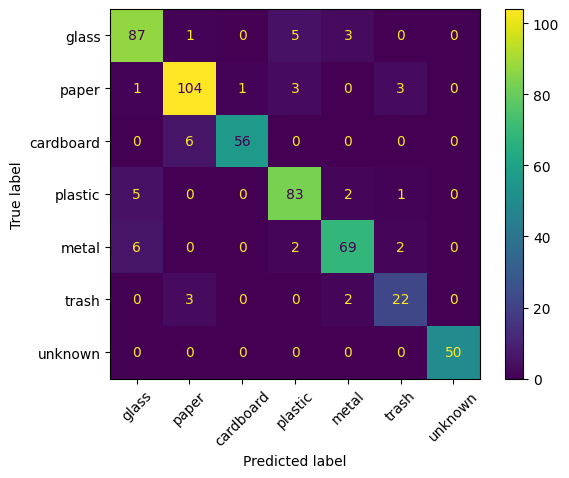

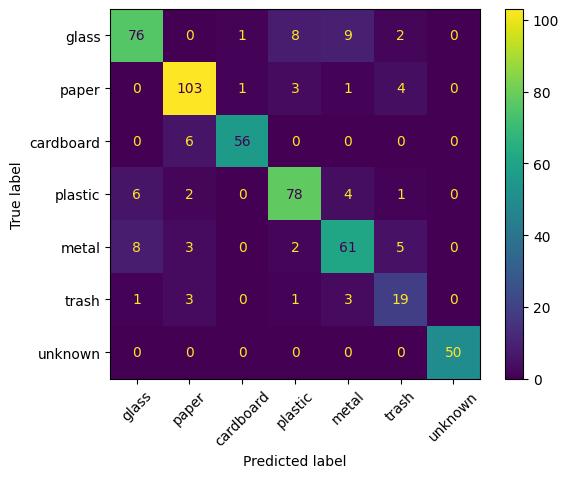

In [17]:

cm = confusion_matrix(test_labels, svc_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot(xticks_rotation=45)
plt.show()


cm = confusion_matrix(test_labels, knn_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot(xticks_rotation=45)
plt.show()

In [24]:
# create this pipeline for future use
svc_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=290, random_state=42)),
    ('svc', SVC(kernel="rbf", C=5, gamma="scale",class_weight="balanced", random_state=42))
])
X_train_features_cnn = cnn_features_extraction(train_files)
svc_pipeline.fit(X_train_features_cnn, train_labels)

,steps,"[('scaler', ...), ('pca', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_components,290
,copy,True
,whiten,False
,svd_solver,'auto'


In [25]:
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=290, random_state=42)),
    ('knn', KNeighborsClassifier(
        n_neighbors=9,
        weights="distance",
        metric="euclidean",
    ))      
])
X_train_features_cnn = cnn_features_extraction(train_files)
knn_pipeline.fit(X_train_features_cnn, train_labels)

,steps,"[('scaler', ...), ('pca', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_components,290
,copy,True
,whiten,False
,svd_solver,'auto'


In [27]:
# test the pipelines
X_test_features_cnn= cnn_features_extraction(test_files)
X_train_features_cnn= cnn_features_extraction(train_files)
svc_pipeline_preds_train = svc_pipeline.predict(X_train_features_cnn)
svc_pipeline_acc_train = accuracy_score(train_labels, svc_pipeline_preds_train)

svc_pipeline_preds_test = svc_pipeline.predict(X_test_features_cnn)
svc_pipeline_acc_test = accuracy_score(test_labels, svc_pipeline_preds_test)

knn_pipeline_preds_train = knn_pipeline.predict(X_train_features_cnn)
knn_pipeline_acc_train = accuracy_score(train_labels, knn_pipeline_preds_train)

knn_pipeline_preds_test = knn_pipeline.predict(X_test_features_cnn)
knn_pipeline_acc_test = accuracy_score(test_labels, knn_pipeline_preds_test)
print(f"SVC Pipeline Train Accuracy: {svc_pipeline_acc_train*100:.2f}%")
print(f"SVC Pipeline Test Accuracy: {svc_pipeline_acc_test*100:.2f}%")
print(f"KNN Pipeline Train Accuracy: {knn_pipeline_acc_train*100:.2f}%")
print(f"KNN Pipeline Test Accuracy: {knn_pipeline_acc_test*100:.2f}%")

SVC Pipeline Train Accuracy: 99.43%
SVC Pipeline Test Accuracy: 91.30%
KNN Pipeline Train Accuracy: 100.00%
KNN Pipeline Test Accuracy: 87.23%


In [28]:

import joblib

os.makedirs("../models", exist_ok=True)

joblib.dump(svc_pipeline, "../models/svc_pipeline.pkl")
joblib.dump(knn_pipeline, "../models/knn_pipeline.pkl")

print("Models saved successfully!")


Models saved successfully!


In [ ]:

svc_pipeline_2 = joblib.load("../models/svc_pipeline.pkl")
knn_pipeline_2 = joblib.load("../models/knn_pipeline.pkl")